# Experiment 005

In this experiment, we again try to improve the block landing model's accuracy.

In [2]:
import os
from pathlib import Path
import random
import shutil
import datetime

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# If running this from VS Code, launch a TensorBoard session on the folder runs/experiment_005

In [3]:
class BlockLandingDataset(Dataset):
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            entry: os.DirEntry = next(iter(it))
            _, self.ext = os.path.splitext(entry.name)
            self.highest_index = max((int(Path(file.path).stem) for file in it))

    def __len__(self):
        return self.highest_index + 1

    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        boards = np.load(file)
        x = boards[:2] # Just take the first two frames as that's what will be input to the main model
        b1 = boards[1] # We can identify a block landing by the fact that a block spawns in the next time step
        b2 = boards[2]
        y = (np.all(b1[0] == 0) & np.any(b2[0] == 1)).astype(np.float32)
        x, y = torch.tensor(x), torch.tensor(y)
        return x, y
        

In [4]:
train_dataset = BlockLandingDataset(os.path.join("data", "block_landing", "train"))
test_dataset = BlockLandingDataset(os.path.join("data", "block_landing", "test"))
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

x, y = next(iter(train_dataloader))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([4, 2, 22, 10]) torch.int32
torch.Size([4]) torch.float32


In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [6]:
class BlockLandingModel(nn.Module):
    """Predicts whether a block has landed.

    Inputs:
        x: Tensor of int32 of shape (batch_size, seq_length, height, width). height = 22 and width = 10 are the dimensions of the game
           board. seq_length = 2 is the number of game board inputs. The entries should be 0 for empty cells and 1 for blocks.
    
    Returns: float32 scalar, logit for block landing prediction.
    """

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.rnn = nn.GRU(5, 5)
        self.norm = nn.BatchNorm1d(5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 0 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        x = self.norm(x)
        logits = self.lin(x).squeeze(-1)
        return logits

In [7]:
model = BlockLandingModel().to(device)
print(model)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    logits = model(X)[0]
    preds = F.sigmoid(logits)
    print(f"Predicted states: {preds}")

BlockLandingModel(
  (conv): Conv2d(2, 5, kernel_size=(3, 3), stride=(1, 1))
  (rnn): GRU(5, 5)
  (norm): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin): Linear(in_features=5, out_features=1, bias=True)
)
Predicted states: 0.46212175488471985


In [47]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    avg_loss = 0.0
    correct = 0.0

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metric calculations
        avg_loss += loss.item()
        classes = (pred >= 0).type(torch.float)
        correct += (classes == y).type(torch.float).mean().item()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    avg_loss /= num_batches
    correct /= num_batches
    print(f"Training accuracy: {(100*correct):>0.1f}%")
    return {
        "loss": avg_loss,
        "acc": correct,
    }


def test_loop(dataloader, model, loss_fn):
    model.eval()
    
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            classes = (pred >= 0).type(torch.float)
            correct += (classes == y).type(torch.float).mean().item()

    test_loss /= num_batches
    correct /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return {
        "loss": test_loss,
        "acc": correct,
    }

# Model architecture

We'll try out a few simpler variations on the architecture to see if it improves the situation.

In [9]:
class ModelWithSimpleRnn(nn.Module):
    """This model has a simple RNN instead of a GRU."""

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.rnn = nn.RNN(5, 5)
        self.norm = nn.BatchNorm1d(5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 0 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        x = self.norm(x)
        logits = self.lin(x).squeeze(-1)
        return logits

In [10]:
class ModelWithSkinnyGru(nn.Module):
    """This model has fewer hidden units in the GRU."""

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.rnn = nn.GRU(5, 3)
        self.norm = nn.BatchNorm1d(3)
        self.lin = nn.Linear(3, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 0 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        x = self.norm(x)
        logits = self.lin(x).squeeze(-1)
        return logits

In [11]:
class ModelWithSimpleRnnAndRelu(nn.Module):
    """This model has a simple RNN instead of a GRU, and the nonlinearity for the RNN is ReLU instead of tanh."""

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.rnn = nn.RNN(5, 5, nonlinearity="relu")
        self.norm = nn.BatchNorm1d(5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 0 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        x = self.norm(x)
        logits = self.lin(x).squeeze(-1)
        return logits

In [20]:
learning_rate = 1e-2
batch_size = 4
epochs = 100

models = {
    "baseline": BlockLandingModel().to(device),
    "simple_rnn": ModelWithSimpleRnn().to(device),
    "skinny_gru": ModelWithSkinnyGru().to(device),
    "simple_rnn_relu": ModelWithSimpleRnnAndRelu().to(device),
}

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for name, model in models.items():
    print(f"Model '{name}' has {count_parameters(model)} parameters.")

log_dir = os.path.join("runs", "experiment_005")
shutil.rmtree(log_dir, ignore_errors=True)

for name, model in models.items():
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    print(f"Training model '{name}'...")
    log_subdir = os.path.join(log_dir, name + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb = SummaryWriter(log_subdir)

    for t in range(epochs):
        print(f"Epoch {t}\n-------------------------------")
        train_metrics = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        tb.add_scalar("Loss/train", train_metrics["loss"], t)
        tb.add_scalar("Accuracy/train", train_metrics["acc"], t)
        tb.add_scalar("Loss/test", test_metrics["loss"], t)
        tb.add_scalar("Accuracy/test", test_metrics["acc"], t)
        for name, weight in model.named_parameters():
            tb.add_histogram(f"Weights/{name}", weight, t)
            tb.add_histogram(f"Gradients/{name}", weight.grad, t)

    tb.close()
    print("Done!")

Model 'baseline' has 291 parameters.
Model 'simple_rnn' has 171 parameters.
Model 'skinny_gru' has 195 parameters.
Model 'simple_rnn_relu' has 171 parameters.
Training model 'baseline'...
Epoch 0
-------------------------------
loss: 0.799639  [    4/  175]
loss: 0.671255  [   84/  175]
loss: 0.443264  [  164/  175]
Test Error: 
 Accuracy: 45.5%, Avg loss: 0.709964 

Epoch 1
-------------------------------
loss: 0.942837  [    4/  175]
loss: 0.599771  [   84/  175]
loss: 0.522847  [  164/  175]
Test Error: 
 Accuracy: 57.6%, Avg loss: 0.714682 

Epoch 2
-------------------------------
loss: 0.476864  [    4/  175]
loss: 0.720447  [   84/  175]
loss: 0.926171  [  164/  175]
Test Error: 
 Accuracy: 61.4%, Avg loss: 0.690937 

Epoch 3
-------------------------------
loss: 0.622770  [    4/  175]
loss: 0.894930  [   84/  175]
loss: 0.731230  [  164/  175]
Test Error: 
 Accuracy: 60.6%, Avg loss: 0.780070 

Epoch 4
-------------------------------
loss: 0.444828  [    4/  175]
loss: 0.632115

We see that the "skinny_gru" model does slightly worse than the baseline, but the "simple_rnn" model trains faster and reaches the same accuracy as the baseline. Using ReLU nonlinearity as opposed to tanh in the simple RNN does not improve accuracy but it does make training more unstable, so we'll stick with the default of tanh nonlinearity.

All the models seem to plateau in their training, suggesting they are stuck in a local minimum or saddle point.

# Learning rate

Let's try reducing the learning rate to see if this helps. We proceed with the simple RNN model because it trains faster.

In [49]:
learning_rates = [1e-2, 7e-3, 5e-3, 3e-3, 2e-3, 1e-3]
batch_size = 4
epochs = 100

log_dir = os.path.join("runs", "experiment_005")
shutil.rmtree(log_dir, ignore_errors=True)

for learning_rate in learning_rates:
    model = ModelWithSimpleRnn().to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    print(f"Training model with learning rate {learning_rate}...")
    log_subdir = os.path.join(log_dir, "learning_rate_" + str(learning_rate).replace(".", "_") + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb = SummaryWriter(log_subdir)

    for t in range(epochs):
        print(f"Epoch {t}\n-------------------------------")
        train_metrics = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        tb.add_scalar("Loss/train", train_metrics["loss"], t)
        tb.add_scalar("Accuracy/train", train_metrics["acc"], t)
        tb.add_scalar("Loss/test", test_metrics["loss"], t)
        tb.add_scalar("Accuracy/test", test_metrics["acc"], t)
        for name, weight in model.named_parameters():
            tb.add_histogram(f"Weights/{name}", weight, t)
            tb.add_histogram(f"Gradients/{name}", weight.grad, t)

    tb.close()
    print("Done!")

Training model with learning rate 0.01...
Epoch 0
-------------------------------
loss: 0.748359  [    4/  175]
loss: 0.738353  [   84/  175]
loss: 0.738133  [  164/  175]
Training accuracy: 59.5%
Test Error: 
 Accuracy: 47.0%, Avg loss: 0.702984 

Epoch 1
-------------------------------
loss: 0.593160  [    4/  175]
loss: 0.672623  [   84/  175]
loss: 0.837723  [  164/  175]
Training accuracy: 61.4%
Test Error: 
 Accuracy: 57.6%, Avg loss: 0.671475 

Epoch 2
-------------------------------
loss: 0.843340  [    4/  175]
loss: 0.871983  [   84/  175]
loss: 0.588309  [  164/  175]
Training accuracy: 66.7%
Test Error: 
 Accuracy: 60.6%, Avg loss: 0.699611 

Epoch 3
-------------------------------
loss: 0.456989  [    4/  175]
loss: 0.516979  [   84/  175]
loss: 0.449448  [  164/  175]
Training accuracy: 68.4%
Test Error: 
 Accuracy: 46.2%, Avg loss: 0.817994 

Epoch 4
-------------------------------
loss: 0.653774  [    4/  175]
loss: 0.815487  [   84/  175]
loss: 0.554173  [  164/  175]


Reducing the learning rate doesn't seem to help much. With the smaller learning rates, the model still hits a plateau, but it takes longer to do so.

Let's train a model with the original learning rate up to high accuracy and see which examples it misclassifies.

In [50]:
learning_rate = 1e-2
batch_size = 4
epochs = 100

# log_dir = os.path.join("runs", "experiment_005")
# shutil.rmtree(log_dir, ignore_errors=True)

model = ModelWithSimpleRnn().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(f"Training model with learning rate {learning_rate}...")
log_subdir = os.path.join(log_dir, "check_failed_examples" + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
tb = SummaryWriter(log_subdir)

for t in range(epochs):
    print(f"Epoch {t}\n-------------------------------")
    train_metrics = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_metrics = test_loop(test_dataloader, model, loss_fn)
    tb.add_scalar("Loss/train", train_metrics["loss"], t)
    tb.add_scalar("Accuracy/train", train_metrics["acc"], t)
    tb.add_scalar("Loss/test", test_metrics["loss"], t)
    tb.add_scalar("Accuracy/test", test_metrics["acc"], t)
    for name, weight in model.named_parameters():
        tb.add_histogram(f"Weights/{name}", weight, t)
        tb.add_histogram(f"Gradients/{name}", weight.grad, t)

tb.close()
print("Done!")

Training model with learning rate 0.01...
Epoch 0
-------------------------------
loss: 0.783997  [    4/  175]
loss: 0.772090  [   84/  175]
loss: 0.696193  [  164/  175]
Training accuracy: 50.9%
Test Error: 
 Accuracy: 47.0%, Avg loss: 0.711370 

Epoch 1
-------------------------------
loss: 0.618617  [    4/  175]
loss: 0.564194  [   84/  175]
loss: 0.548184  [  164/  175]
Training accuracy: 50.4%
Test Error: 
 Accuracy: 46.2%, Avg loss: 0.709814 

Epoch 2
-------------------------------
loss: 0.576809  [    4/  175]
loss: 0.537328  [   84/  175]
loss: 0.615767  [  164/  175]
Training accuracy: 56.4%
Test Error: 
 Accuracy: 59.8%, Avg loss: 0.726111 

Epoch 3
-------------------------------
loss: 0.600720  [    4/  175]
loss: 0.614087  [   84/  175]
loss: 0.442822  [  164/  175]
Training accuracy: 65.9%
Test Error: 
 Accuracy: 49.2%, Avg loss: 0.740103 

Epoch 4
-------------------------------
loss: 0.826048  [    4/  175]
loss: 0.565614  [   84/  175]
loss: 0.638182  [  164/  175]


In [53]:
# Find indices of all failed training predictions

failed_train_idxs = []

with torch.no_grad():
    for idx, (x, y) in enumerate(train_dataset):
        pred = model(x.unsqueeze(0)).squeeze(0)
        pred = (pred >= 0.0).type(torch.float)
        correct = (pred == y).item()
        if not correct:
            failed_train_idxs.append(idx)

print(f"The model failed on training examples {failed_train_idxs}.")

The model failed on training examples [28, 35, 60, 65, 73, 138, 163].


Correct prediction: False


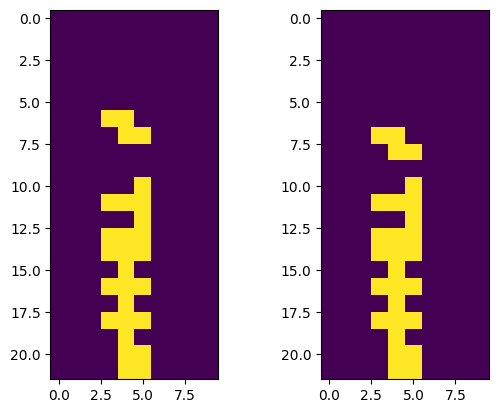

In [72]:
idx = random.choice(failed_train_idxs)
x, y = train_dataset[idx]
print(f"Correct prediction: {bool(y)}")

fig, axs = plt.subplots(1, 2)
axs = axs.flatten()

axs[0].imshow(x[0])
axs[1].imshow(x[1])

The failed training predictions are all when the block is fairly close to landing, but not quite there yet. This suggests that the model is starting to generalise correctly.

In [77]:
# Find indices of all failed test predictions

failed_test_idxs = []

with torch.no_grad():
    for idx, (x, y) in enumerate(test_dataset):
        pred = model(x.unsqueeze(0)).squeeze(0)
        pred = (pred >= 0.0).type(torch.float)
        correct = (pred == y).item()
        if not correct:
            failed_test_idxs.append(idx)

print(f"The model failed on test examples {failed_test_idxs}.")

The model failed on test examples [2, 7, 21, 25].


Correct prediction: False


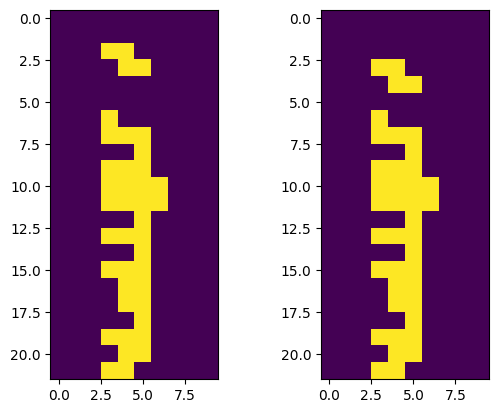

In [93]:
idx = random.choice(failed_test_idxs)
x, y = test_dataset[idx]
print(f"Correct prediction: {bool(y)}")

fig, axs = plt.subplots(1, 2)
axs = axs.flatten()

axs[0].imshow(x[0])
axs[1].imshow(x[1])

# Momentum

Assuming the optimization is stuck in a local minimum, let's try and use momentum to help it out.

In [95]:
learning_rate = 1e-2
momenta = [0.0, 9e-1, 1e-1, 1e-2]
batch_size = 4
epochs = 100

log_dir = os.path.join("runs", "experiment_005")
shutil.rmtree(log_dir, ignore_errors=True)

for momentum in momenta:
    model = ModelWithSimpleRnn().to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    print(f"Training model with momentum {momentum}...")
    log_subdir = os.path.join(log_dir, "momentum_" + str(momentum).replace(".", "_") + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb = SummaryWriter(log_subdir)

    for t in range(epochs):
        print(f"Epoch {t}\n-------------------------------")
        train_metrics = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        tb.add_scalar("Loss/train", train_metrics["loss"], t)
        tb.add_scalar("Accuracy/train", train_metrics["acc"], t)
        tb.add_scalar("Loss/test", test_metrics["loss"], t)
        tb.add_scalar("Accuracy/test", test_metrics["acc"], t)
        for name, weight in model.named_parameters():
            tb.add_histogram(f"Weights/{name}", weight, t)
            tb.add_histogram(f"Gradients/{name}", weight.grad, t)

    tb.close()
    print("Done!")

Training model with momentum 0.0...
Epoch 0
-------------------------------
loss: 0.730849  [    4/  175]
loss: 0.786646  [   84/  175]
loss: 0.886391  [  164/  175]
Training accuracy: 63.6%
Test Error: 
 Accuracy: 47.0%, Avg loss: 0.694215 

Epoch 1
-------------------------------
loss: 0.564717  [    4/  175]
loss: 0.471649  [   84/  175]
loss: 0.493317  [  164/  175]
Training accuracy: 65.0%
Test Error: 
 Accuracy: 58.3%, Avg loss: 0.665658 

Epoch 2
-------------------------------
loss: 0.779601  [    4/  175]
loss: 0.653584  [   84/  175]
loss: 0.680656  [  164/  175]
Training accuracy: 67.0%
Test Error: 
 Accuracy: 58.3%, Avg loss: 0.675457 

Epoch 3
-------------------------------
loss: 0.569196  [    4/  175]
loss: 0.503453  [   84/  175]
loss: 0.791745  [  164/  175]
Training accuracy: 68.2%
Test Error: 
 Accuracy: 64.4%, Avg loss: 0.724541 

Epoch 4
-------------------------------
loss: 0.805988  [    4/  175]
loss: 0.527514  [   84/  175]
loss: 0.783933  [  164/  175]
Traini

Adding momentum doesn't seem to make any difference.

# Different optimizer

What if we try a different optimizer, like Adam?

In [97]:
learning_rate = 1e-3
batch_size = 4
epochs = 100

log_dir = os.path.join("runs", "experiment_005")
shutil.rmtree(log_dir, ignore_errors=True)

model = ModelWithSimpleRnn().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Training model with Adam...")
log_subdir = os.path.join(log_dir, "adam" + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
tb = SummaryWriter(log_subdir)

for t in range(epochs):
    print(f"Epoch {t}\n-------------------------------")
    train_metrics = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_metrics = test_loop(test_dataloader, model, loss_fn)
    tb.add_scalar("Loss/train", train_metrics["loss"], t)
    tb.add_scalar("Accuracy/train", train_metrics["acc"], t)
    tb.add_scalar("Loss/test", test_metrics["loss"], t)
    tb.add_scalar("Accuracy/test", test_metrics["acc"], t)
    for name, weight in model.named_parameters():
        tb.add_histogram(f"Weights/{name}", weight, t)
        tb.add_histogram(f"Gradients/{name}", weight.grad, t)

tb.close()
print("Done!")

Training model with learning rate 0.001...
Epoch 0
-------------------------------
loss: 0.791628  [    4/  175]
loss: 0.679644  [   84/  175]
loss: 0.579722  [  164/  175]
Training accuracy: 57.2%
Test Error: 
 Accuracy: 46.2%, Avg loss: 0.697320 

Epoch 1
-------------------------------
loss: 0.671694  [    4/  175]
loss: 0.517959  [   84/  175]
loss: 0.714158  [  164/  175]
Training accuracy: 73.7%
Test Error: 
 Accuracy: 62.1%, Avg loss: 0.641724 

Epoch 2
-------------------------------
loss: 0.464552  [    4/  175]
loss: 0.483080  [   84/  175]
loss: 0.563936  [  164/  175]
Training accuracy: 73.3%
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.621852 

Epoch 3
-------------------------------
loss: 0.641107  [    4/  175]
loss: 0.448335  [   84/  175]
loss: 0.427998  [  164/  175]
Training accuracy: 75.6%
Test Error: 
 Accuracy: 52.3%, Avg loss: 1.226841 

Epoch 4
-------------------------------
loss: 0.444489  [    4/  175]
loss: 0.496113  [   84/  175]
loss: 0.841778  [  164/  175]

Nope, that doesn't seem to help.

# Regularization

L2 regularization might at least make the training more stable.

In [100]:
learning_rate = 1e-2
l2_regs = [0, 1e-3, 1e-2, 1e-1]
batch_size = 4
epochs = 100

log_dir = os.path.join("runs", "experiment_005")
shutil.rmtree(log_dir, ignore_errors=True)

for l2_reg in l2_regs:
    model = ModelWithSimpleRnn().to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_reg)

    print(f"Training model with L2 regularization {l2_reg}...")
    log_subdir = os.path.join(log_dir, "l2_reg_" + str(l2_reg) + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb = SummaryWriter(log_subdir)

    for t in range(epochs):
        print(f"Epoch {t}\n-------------------------------")
        train_metrics = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        tb.add_scalar("Loss/train", train_metrics["loss"], t)
        tb.add_scalar("Accuracy/train", train_metrics["acc"], t)
        tb.add_scalar("Loss/test", test_metrics["loss"], t)
        tb.add_scalar("Accuracy/test", test_metrics["acc"], t)
        # for name, weight in model.named_parameters():
        #     tb.add_histogram(f"Weights/{name}", weight, t)
        #     tb.add_histogram(f"Gradients/{name}", weight.grad, t)

    tb.close()
    print("Done!")

Training model with L2 regularization 0...
Epoch 0
-------------------------------
loss: 0.761756  [    4/  175]
loss: 0.524852  [   84/  175]
loss: 0.626425  [  164/  175]
Training accuracy: 56.1%
Test Error: 
 Accuracy: 47.0%, Avg loss: 0.707432 

Epoch 1
-------------------------------
loss: 0.561244  [    4/  175]
loss: 0.563479  [   84/  175]
loss: 0.710015  [  164/  175]
Training accuracy: 63.4%
Test Error: 
 Accuracy: 47.0%, Avg loss: 0.727187 

Epoch 2
-------------------------------
loss: 0.685253  [    4/  175]
loss: 0.462435  [   84/  175]
loss: 0.745215  [  164/  175]
Training accuracy: 61.0%
Test Error: 
 Accuracy: 47.0%, Avg loss: 1.592807 

Epoch 3
-------------------------------
loss: 0.647031  [    4/  175]
loss: 0.568999  [   84/  175]
loss: 0.522665  [  164/  175]
Training accuracy: 63.4%
Test Error: 
 Accuracy: 74.2%, Avg loss: 0.604766 

Epoch 4
-------------------------------
loss: 0.592939  [    4/  175]
loss: 0.839033  [   84/  175]
loss: 0.620034  [  164/  175]

The regularization doesn't do anything for the training stability. A small amount of regularization does seem to speed up training slightly, but not enough for it to be worth the increased complexity.

# Model architecture 2

Now that we've seen the benefit of the simple RNN structure, let's change other aspects of the model architecture and see if it improves the performance.

In [102]:
class SimpleRnnWithWiderRnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.rnn = nn.RNN(5, 10)
        self.norm = nn.BatchNorm1d(10)
        self.lin = nn.Linear(10, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 0 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        x = self.norm(x)
        logits = self.lin(x).squeeze(-1)
        return logits

In [103]:
class SimpleRnnWithLinearBeforeRnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 5, 3)
        self.lin0 = nn.Linear(5, 5)
        self.rnn = nn.RNN(5, 5)
        self.norm = nn.BatchNorm1d(5)
        self.lin1 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 0 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.avg_pool2d(x1, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)
        x1 = F.relu(self.lin0(x1))

        x2 = F.relu(self.conv(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)
        x2 = F.relu(self.lin0(x2))

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        x = self.norm(x)
        logits = self.lin1(x).squeeze(-1)
        return logits

In [104]:
class SimpleRnnWithExtraConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 5, 3)
        self.conv1 = nn.Conv2d(5, 5, 3)
        self.rnn = nn.RNN(5, 5)
        self.norm = nn.BatchNorm1d(5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 0 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv0(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.relu(self.conv1(F.pad(x1, (1, 1, 1, 1))))
        x1 = F.avg_pool2d(x1, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x2 = F.relu(self.conv0(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.relu(self.conv1(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        x = self.norm(x)
        logits = self.lin(x).squeeze(-1)
        return logits

In [106]:
class SimpleRnnWithExtraWideConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 5, 3)
        self.conv1 = nn.Conv2d(5, 10, 3)
        self.rnn = nn.RNN(10, 5)
        self.norm = nn.BatchNorm1d(5)
        self.lin = nn.Linear(5, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((1, 0, 4, 2, 3)) # Move sequence to dimension 0 and channels/classes to dimension 2
        x1, x2 = x # Split up the two timesteps so we can apply convolution to them both separately

        x1 = F.relu(self.conv0(F.pad(x1, (1, 1, 1, 1)))) # Pad height and width (the last 2 dimensions) with zeroes to represent the board boundaries
        x1 = F.relu(self.conv1(F.pad(x1, (1, 1, 1, 1))))
        x1 = F.avg_pool2d(x1, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x2 = F.relu(self.conv0(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.relu(self.conv1(F.pad(x2, (1, 1, 1, 1))))
        x2 = F.avg_pool2d(x2, kernel_size=x.shape[-2:]).squeeze(-1).squeeze(-1)

        x = torch.concat((x1.unsqueeze(0), x2.unsqueeze(0)))
        x, rnn_state = self.rnn(x)
        x = x[-1] # Just take last predicted state
        x = self.norm(x)
        logits = self.lin(x).squeeze(-1)
        return logits

In [107]:
learning_rate = 1e-2
batch_size = 4
epochs = 100

models = {
    "simple_rnn": ModelWithSimpleRnn().to(device),
    "wider": SimpleRnnWithWiderRnn().to(device),
    "linear_before_rnn": SimpleRnnWithLinearBeforeRnn().to(device),
    "extra_conv": SimpleRnnWithExtraConv().to(device),
    "extra_wide_conv": SimpleRnnWithExtraWideConv().to(device),
}

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for name, model in models.items():
    print(f"Model '{name}' has {count_parameters(model)} parameters.")

log_dir = os.path.join("runs", "experiment_005")
shutil.rmtree(log_dir, ignore_errors=True)

for name, model in models.items():
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    print(f"Training model '{name}'...")
    log_subdir = os.path.join(log_dir, name + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb = SummaryWriter(log_subdir)

    for t in range(epochs):
        print(f"Epoch {t}\n-------------------------------")
        train_metrics = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        tb.add_scalar("Loss/train", train_metrics["loss"], t)
        tb.add_scalar("Accuracy/train", train_metrics["acc"], t)
        tb.add_scalar("Loss/test", test_metrics["loss"], t)
        tb.add_scalar("Accuracy/test", test_metrics["acc"], t)
        for name, weight in model.named_parameters():
            tb.add_histogram(f"Weights/{name}", weight, t)
            tb.add_histogram(f"Gradients/{name}", weight.grad, t)

    tb.close()
    print("Done!")

Model 'simple_rnn' has 171 parameters.
Model 'wider' has 296 parameters.
Model 'linear_before_rnn' has 201 parameters.
Model 'extra_conv' has 401 parameters.
Model 'extra_wide_conv' has 656 parameters.
Training model 'simple_rnn'...
Epoch 0
-------------------------------
loss: 0.809214  [    4/  175]
loss: 0.939461  [   84/  175]
loss: 0.602728  [  164/  175]
Training accuracy: 65.2%
Test Error: 
 Accuracy: 46.2%, Avg loss: 0.720875 

Epoch 1
-------------------------------
loss: 0.826274  [    4/  175]
loss: 0.920830  [   84/  175]
loss: 0.589147  [  164/  175]
Training accuracy: 67.2%
Test Error: 
 Accuracy: 45.5%, Avg loss: 2.209103 

Epoch 2
-------------------------------
loss: 0.827679  [    4/  175]
loss: 0.652182  [   84/  175]
loss: 0.551580  [  164/  175]
Training accuracy: 67.4%
Test Error: 
 Accuracy: 62.9%, Avg loss: 0.654149 

Epoch 3
-------------------------------
loss: 0.775076  [    4/  175]
loss: 0.553623  [   84/  175]
loss: 0.847242  [  164/  175]
Training accurac

There is no clear winner here; the models all perform about the same.

# Conclusion

We have tried a range of approaches to get past the plateau and get to 100% accuracy. Most approaches did not seem to help, but we did find that a simple RNN trains faster than a GRU for this task and performs just as well, so we will adapt the main block landing model architecture accordingly.

It's interesting to note that all the misclassified examples examined in this experiment were false positives (i.e. block was predicted to land but it didn't). False negatives are more impactful in our case, so the block landing model might already be in a state where we can integrate it into the Tetris emulator as a pre-trained component. It would also be interesting to see the precision-recall curve for the block landing model to see how well it can separate the two classes.

Another thing we can try to improve the predictions of the block landing model is to give it sequences of length 3 instead of length 2 as input. Having more timesteps might give the model more useful information with which to predict the block landing.